In [1]:
# Q&A applications want to allow the user to have a back and forth conversation , meaning the applicatoin needs memory of past Q&A and some logic to incorporate that into current thinkiing

We will cover two approaches:

1. Chains, in which we always execute a retrieval step;
2. Agents, in which we give an LLM discretion over whether and how to execute a retrieval step (or multiple steps).

## Chains 

In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
os.environ["LANGCHAIN_TRACING_V2"] = "true"

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model = "gpt-3.5-turbo")

import bs4
from langchain import hub
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)

docs = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1000 , chunk_overlap = 200)
splits = text_splitter.split_documents(docs)
vector_store = Chroma.from_documents(documents=splits , embedding= OpenAIEmbeddings())
retriever = vector_store.as_retriever()


system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}")
    ])

question_answer_chain = create_stuff_documents_chain(llm , prompt)
rag_chain = create_retrieval_chain(retriever , question_answer_chain)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
response = rag_chain.invoke({"input": "What is Task Decomposition?"})
response["answer"]

'Task Decomposition involves breaking down complex tasks into smaller and simpler steps to make them more manageable and easier to complete. This process can be done using techniques like Chain of Thought or Tree of Thoughts, which help agents plan and execute tasks more effectively by dividing them into sequential or branching subtasks. Task decomposition can be achieved through simple prompting with language models, task-specific instructions, or human inputs.'

Note that we have used the built-in chain constructors create_stuff_documents_chain and create_retrieval_chain, so that the basic ingredients to our solution are:

1. retriever;
2. prompt;
3. LLM.

### Add Chat History

The chain we have built uses the input query directly to retrieve relevant context. But in a conversational setting, the user query might require conversational context to be understood. 

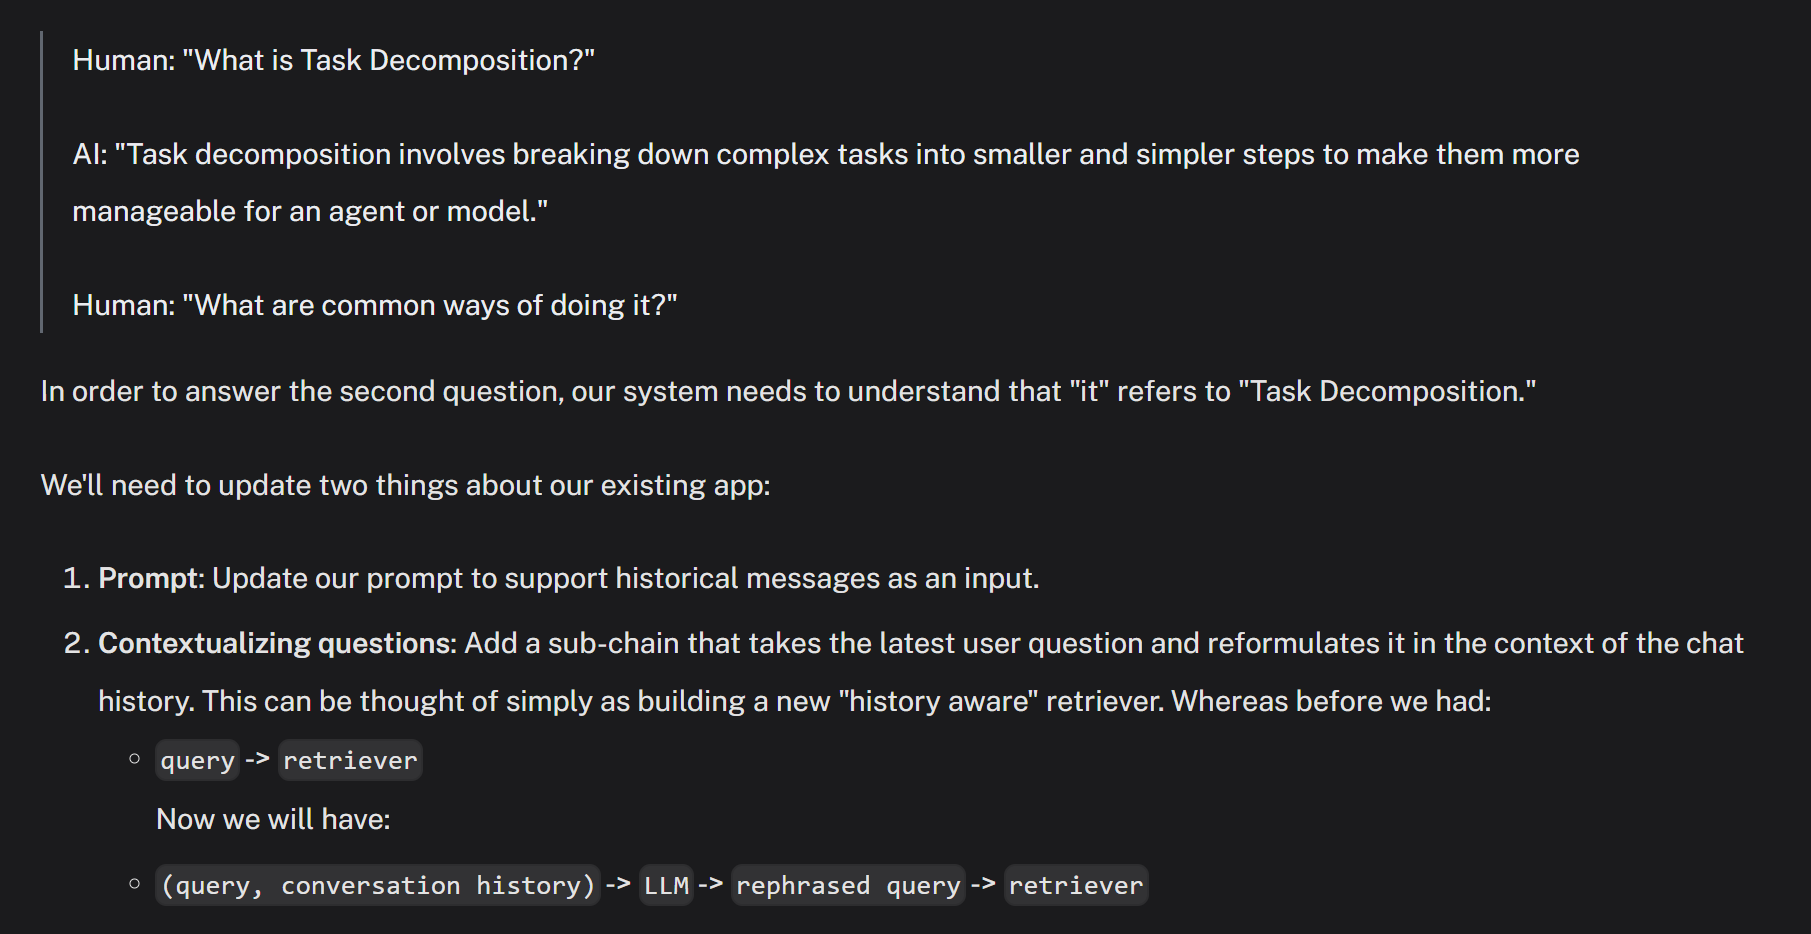

contextualize the question : define a sub chain that takes historical messages and latest user question , and formulates the question if makes reference to any information in the historical information.

Note that we leverage a helper function `create_history_aware_retriever` for this step, which manages the case where chat_history is empty, and otherwise applies prompt | llm | StrOutputParser() | retriever in sequence.

In [4]:
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import MessagesPlaceholder

contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)

contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)

# This chain prepends rephrasing of the input query to our retriever , so retreiver incorporates context in conversation
# use create_stuff_documents_chain to generate a question_answer_chain, with input keys context, chat_history, and input
# final rag_chain with create_retrieval_chain. This chain applies the history_aware_retriever and question_answer_chain in sequence, 
# retaining intermediate outputs such as the retrieved context for convenience. It has input keys input and chat_history, and includes input, chat_history, context, and answer in its output.

In [5]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

qa_prompt = ChatPromptTemplate.from_messages([
    ("system" , system_prompt),
    MessagesPlaceholder("chat_history"),
    ("human" , "{input}")
])

question_answer_chain = create_stuff_documents_chain(llm , qa_prompt)
rag_chain = create_retrieval_chain( history_aware_retriever , question_answer_chain) # instead of the nomral retreiver we use the history aware retreiver

In [ ]:
# Below when we ask a question and a follow up (requires contextualization with chat_hostory ) , we need to manage chat_history. 

Manual addition of chat history

In [7]:
from langchain_core.messages import AIMessage , HumanMessage
chat_history = []

question = "what is Task Decomposition?"
ai_msg_1 = rag_chain.invoke({"input": question , "chat_history" : chat_history})


question_2 = "what are the common ways to do it?"
ai_msg_2 = rag_chain.invoke({"input": question_2 , "chat_history" : chat_history})
print(ai_msg_2["answer"])

Task decomposition can be achieved through various methods like using simple prompts for LLMs, providing task-specific instructions, or incorporating human inputs. Additionally, approaches like the Tree of Thoughts model explore multiple reasoning possibilities by generating multiple thoughts per step in a tree structure. External tools can also be used to enhance LLM capabilities, allowing them to create, modify, and utilize objects beyond their own limits.


Automatic insertion of Chat history:

1. BaseChatMessageHistory: Store chat history.
2. RunnableWithMessageHistory: Wrapper for an LCEL chain and a BaseChatMessageHistory that handles injecting chat history into inputs and updating it after each invocation.

check this for more detailed walk through : https://python.langchain.com/v0.2/docs/how_to/message_history/



In [8]:
# a simple example of the second method :> using a dict
# Langchain manages memory integrations with Redis

In [9]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

stores = {}

def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in stores:
        stores[session_id] = ChatMessageHistory()
    return stores[session_id]

conversational_rag_chain = RunnableWithMessageHistory(rag_chain , get_session_history , input_messages_key= "input" , history_messages_key= "chat_history" , output_messages_key="answer")

In [10]:
config = {"configurable" : {"session_id" : "abc123"}}
conversational_rag_chain.invoke({"input" : "what is Task Decomposition?"} ,config=config)["answer"]

Parent run 28857fec-18cb-4c97-b3bf-f428cd8e9d3e not found for run e00b956c-26f4-4e3b-b8a0-e936ba46d407. Treating as a root run.


'Task decomposition involves breaking down a complex task into smaller and more manageable steps. This process allows agents or models to better understand the task at hand and plan their approach accordingly. Techniques like Chain of Thought and Tree of Thoughts help in decomposing hard tasks into simpler steps for easier execution.'

In [12]:
conversational_rag_chain.invoke({"input" : "what are the common ways of doing it?"} ,config=config)["answer"]

Parent run 47f9d483-255b-4561-940b-b00d98049cd5 not found for run a1d3753b-0b73-4db7-af2f-816fa1a8ef5b. Treating as a root run.


'Task decomposition can be done by using prompting techniques with language models, providing task-specific instructions, or incorporating human inputs. Additionally, techniques like Chain of Thought (CoT) and Tree of Thoughts explore multiple reasoning possibilities at each step, creating a structured approach to breaking down complex tasks.'

Inspect the messages in the store dict 

In [14]:
stores["abc123"].messages

[HumanMessage(content='what is Task Decomposition?'),
 AIMessage(content='Task decomposition involves breaking down a complex task into smaller and more manageable steps. This process allows agents or models to better understand the task at hand and plan their approach accordingly. Techniques like Chain of Thought and Tree of Thoughts help in decomposing hard tasks into simpler steps for easier execution.'),
 HumanMessage(content='what are the common ways of doing it?'),
 AIMessage(content='Task decomposition can be achieved in various ways, such as using prompting techniques like "Steps for XYZ" with language models, providing task-specific instructions like "Write a story outline," or incorporating human inputs to guide the decomposition process. Additionally, techniques like Chain of Thought (CoT) and Tree of Thoughts explore multiple reasoning possibilities at each step, creating a structured approach to task decomposition.'),
 HumanMessage(content='what are the common ways of doin

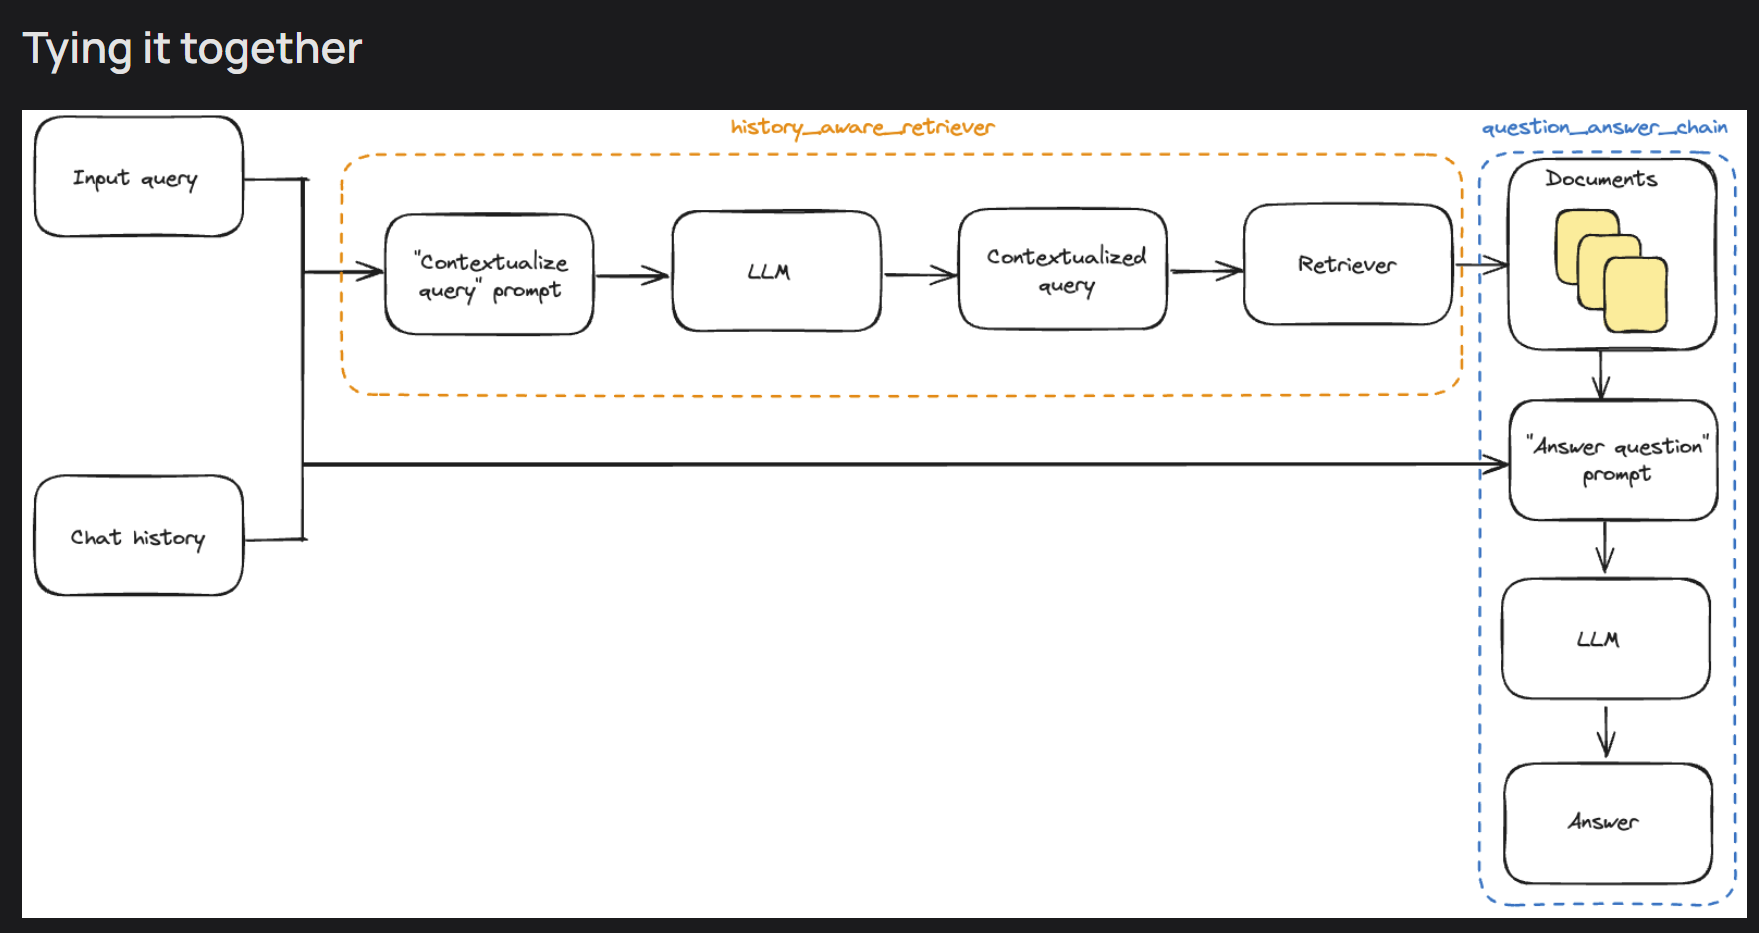

### Grouping all the code together

In [22]:
import bs4 
from langchain.chains import create_history_aware_retriever , create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_chroma import Chroma
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_openai import OpenAIEmbeddings , ChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

loader = WebBaseLoader(web_path=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),)

docs = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1000 , chunk_overlap = 200)
splits = text_splitter.split_documents(docs)
vector_store = Chroma.from_documents(documents=splits , embedding= OpenAIEmbeddings())
retriever  = vector_store.as_retriever() # this can be any retriever

# chains we need
# 1. contextualize the question : (history , input question)
# 2. q_a chain
# 3. rag chain
# 4. message chat history chain

# 1 Contextualize Q chain
contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)

contextualize_q_prompt = ChatPromptTemplate.from_messages([
    ("system" , contextualize_q_system_prompt),
    MessagesPlaceholder("chat_history"),
    ("human" , "{input}"),
])

history_aware_retriever = create_history_aware_retriever( llm , retriever , contextualize_q_prompt)

# Q_A chain
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

qa_prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder("chat_history"),
    ("human","{input}")
])

question_answer_chain = create_stuff_documents_chain(llm , qa_prompt)

# rag chain
rag_chain = create_retrieval_chain(history_aware_retriever , question_answer_chain)

# add history
stores = {}

def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in stores:
        stores[session_id] = ChatMessageHistory()
    return stores[session_id]

conversational_rag_chain = RunnableWithMessageHistory(rag_chain , get_session_history , input_messages_key= "input" , history_messages_key="chat_history" , output_messages_key= "answer")


In [23]:
config = {"configurable" : {"session_id" : "abc123"}}
conversational_rag_chain.invoke({"input" : "what is Task Decomposition?"} ,config=config)["answer"]

conversational_rag_chain.invoke({"input" : "what are the common ways of doing it?"} ,config=config)["answer"]



Parent run 3d480114-042d-482b-b431-33cbe705cb75 not found for run 100dc9ec-e4e7-40d3-9509-68358a7f1a24. Treating as a root run.
Parent run 44398bbd-c96a-46e0-99c9-65e534095a24 not found for run 3a7d29d8-5c23-427a-98c3-c3ad5cf28bc6. Treating as a root run.


'Task decomposition can be achieved through various methods such as using language models with simple prompting, providing task-specific instructions, or incorporating human inputs. For example, one can prompt a language model with instructions like "Steps for XYZ" or "What are the subgoals for achieving XYZ?" Another approach is to give specific task instructions like "Write a story outline" for tasks such as writing a novel. Additionally, human inputs can also be utilized for task decomposition to provide guidance and insights into breaking down complex tasks.'

In [24]:
stores["abc123"].messages

[HumanMessage(content='what is Task Decomposition?'),
 AIMessage(content='Task Decomposition is a technique used to break down complex tasks into smaller and simpler steps. It involves transforming big tasks into multiple manageable tasks to make them easier to accomplish. This approach helps agents or models to better understand and interpret the thinking process involved in completing a task.'),
 HumanMessage(content='what are the common ways of doing it?'),
 AIMessage(content='Task decomposition can be achieved through various methods such as using language models with simple prompting, providing task-specific instructions, or incorporating human inputs. For example, one can prompt a language model with instructions like "Steps for XYZ" or "What are the subgoals for achieving XYZ?" Another approach is to give specific task instructions like "Write a story outline" for tasks such as writing a novel. Additionally, human inputs can also be utilized for task decomposition to provide gui

## Agents

In [ ]:
# Agents behaviour is less predictable than chain , but they offer advantages in the context:
# 1. Agents generate the input to the retriever directly, without necessarily needing us to explicitly build in contextualization, as we did above;
# 2. Agents can execute multiple retrieval steps in service of a query, or refrain from executing a retrieval step altogether (e.g., in response to a generic greeting from a user).

#### Retrieval Tool

1. Agents can access tools and manage their execution . we will convert our retriever into a Langchain tool to be wielded by agent 


In [25]:
from langchain.tools.retriever import create_retriever_tool

tool = create_retriever_tool( retriever, name = "blog_post_retriever" , description= "search and return excerpts from the Autonomous Agents blog post")
tools = [tool]
tool.invoke("task decompostion")

'Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\n\nFig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by st

#### Agent constructor

we use langgrpah to construct the agent.  LangGraph is  high-level interface is backed by a low-level, highly controllable API in case you want to modify the agent logic.

In [26]:
from langgraph.prebuilt import create_react_agent
agent_executor = create_react_agent(llm , tools)

query = "what is Task Decomposition?"

for s in agent_executor.stream({"messages" :[HumanMessage(content=query)]}):
    print(s , end = "--")

{'agent': {'messages': [AIMessage(content='Task decomposition is a problem-solving strategy that involves breaking down a complex task or problem into smaller, more manageable subtasks. By decomposing a task into smaller components, it becomes easier to understand, analyze, and solve each individual part. This approach allows for better organization, delegation of responsibilities, and more efficient problem-solving. Task decomposition is commonly used in various fields such as project management, software development, and problem-solving methodologies like the Divide and Conquer algorithm.', response_metadata={'token_usage': {'completion_tokens': 93, 'prompt_tokens': 68, 'total_tokens': 161}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-f93a4606-93dd-49ae-8d81-f54b14ba05f8-0', usage_metadata={'input_tokens': 68, 'output_tokens': 93, 'total_tokens': 161})]}}--

Langgrpah comes with a built in persistence , so we don't need to use ChatMessageHistory! Rather, we can pass in a checkpointer to our LangGraph agent directly

In [28]:
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver.from_conn_string(":memory:")
agent_executor = create_react_agent(llm , tools , checkpointer= memory)

config = {"configurable" : {"thread_id" : "abcd1234"}}
for s in agent_executor.stream({"messages" :[ HumanMessage(content= "Hi, I am Roy")] } , config = config):
    print(s , end = "--")

{'agent': {'messages': [AIMessage(content='Hello Roy! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 67, 'total_tokens': 78}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-9bd0de17-add6-4d93-83e0-36bd1351a5ea-0', usage_metadata={'input_tokens': 67, 'output_tokens': 11, 'total_tokens': 78})]}}--

In [30]:
query  = "What is Task Decomposition"
for s in agent_executor.stream({"messages" :[ HumanMessage(content= query)] } , config = config):
    print(s)
    print("---")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9vnbm8INNcvWNOve8RSs1ZN7', 'function': {'arguments': '{"query":"Task Decomposition"}', 'name': 'blog_post_retriever'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 171, 'total_tokens': 190}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1ad82416-f24d-45fe-be27-b30e744bc5d9-0', tool_calls=[{'name': 'blog_post_retriever', 'args': {'query': 'Task Decomposition'}, 'id': 'call_9vnbm8INNcvWNOve8RSs1ZN7'}], usage_metadata={'input_tokens': 171, 'output_tokens': 19, 'total_tokens': 190})]}}
---
{'tools': {'messages': [ToolMessage(content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 20

Above, instead of inserting our query verbatim into the tool, the agent stripped unnecessary words like "what" and "is". This same principle allows the agent to use the context of the conversation when necessary:

In [31]:
query = "What according to the blog post are common ways of doing it? redo the search"

for s in agent_executor.stream({"messages": [HumanMessage(content=query)]}, config=config):
    print(s)
    print("----")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jROn1QkLx4p8RjFaA13D2cbQ', 'function': {'arguments': '{"query":"common ways of task decomposition"}', 'name': 'blog_post_retriever'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 833, 'total_tokens': 854}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8094ed72-e7d2-42ae-a983-c0ed987b52fb-0', tool_calls=[{'name': 'blog_post_retriever', 'args': {'query': 'common ways of task decomposition'}, 'id': 'call_jROn1QkLx4p8RjFaA13D2cbQ'}], usage_metadata={'input_tokens': 833, 'output_tokens': 21, 'total_tokens': 854})]}}
----
{'tools': {'messages': [ToolMessage(content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creat

#### all code together

In [ ]:
import bs4
from langchain.agents import AgentExecutor, create_tool_calling_agent #
from langchain.tools.retriever import create_retriever_tool
from langchain_chroma import Chroma
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")
llm = ChatOpenAI( model = "gpt-3.5-turbo" )

### Construct retriever ###
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())
retriever = vectorstore.as_retriever()

tool = create_retriever_tool(
    retriever,
    name = "blog_post_retriever",
    description= "Searches and returns excerpts from the Autonomous Agents blog post.",
)
tools = [tool]

agent_executor = create_react_agent(llm , tools= tools , checkpointer= memory)
